# **NASDAQ Trading at the Close**

This project aims to develop a predictive model for short-term closing price movements of hundreds of Nasdaq-listed stocks, utilizing order book and auction system data from the final ten minutes of the trading session.
The Nasdaq closing price is determined each day through a closing auction mechanism, which serves as an essential benchmark for market participants, institutional investors, and analysts when evaluating the market and individual securities.

During the last ten minutes before the close, trading activity, volatility, and liquidity peak, and a wide range of information is generated from both the limit order book and the auction book. By systematically analyzing key indicators—such as price levels, trade volume, and supply-demand imbalances—this project provides practical insight into the mechanics of closing price formation.
The approach is based on real exchange data, applying time-series and regression-based machine learning methods to forecast the movement of the volume-weighted average price (WAP) 60 seconds into the future.

- stock_id - A unique identifier for the stock. Not all stock IDs exist in every time bucket

- date_id - A unique identifier for the date. Date IDs are sequential & consistent across all stocks

- imbalance_size - The amount unmatched at the current reference price (in USD)

- imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance
  - buy-side imbalance; 1
  - sell-side imbalance; -1
  - no imbalance; 0

- reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price

- matched_size - The amount that can be matched at the current reference price (in USD)

- far_price - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders

- near_price - The crossing price that will maximize the number of shares matched based auction and continuous market orders

- [bid/ask]_price - Price of the most competitive buy/sell level in the non-auction book

- [bid/ask]_size - The dollar notional amount on the most competitive buy/sell level in the non-auction book

- wap - The weighted average price in the non-auction book

- seconds_in_bucket - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0

- target - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set
  - The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition
  - The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move
  - Where t is the time at the current observation, we can define the target

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 24.9 MB/s eta 0:00:00


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.8 MB/s eta 0:00:00


## **I. Import Required Libraries and Environment Settings**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc, os, random, warnings
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

warnings.filterwarnings('ignore')
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.keras.utils.set_random_seed(seed)
sns.set_theme(style='white', palette='viridis')

## **II. Data Loading**

In [5]:
TRAIN_PATH = '/content/drive/MyDrive/DataAnalytics/train.csv'
TEST_PATH = '/content/drive/MyDrive/DataAnalytics/test.csv'
SUB_PATH = '/content/drive/MyDrive/DataAnalytics/submission.csv'
RVL_PATH = '/content/drive/MyDrive/DataAnalytics/revealed_targets.csv'

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
submission = pd.read_csv(SUB_PATH)
revealed_targets = pd.read_csv(RVL_PATH)
print("Train:", train.shape, "Test:", test.shape, "Submission:", submission.shape, "Revealed_targets:", revealed_targets.shape)

gc.collect()

Train: (5237980, 17) Test: (33000, 17) Submission: (33000, 3) Revealed_targets: (33162, 7)


0

In [6]:
train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [7]:
submission.head()

,time_id,row_id,target
0,26290,478_0_0,-2.745822
1,26290,478_0_1,0.415957
2,26290,478_0_2,3.763928
3,26290,478_0_3,-0.210446
4,26290,478_0_4,-1.367473


In [8]:
revealed_targets.head()

,stock_id,date_id,seconds_in_bucket,time_id,revealed_target,revealed_date_id,revealed_time_id
0,0.0,478,0,26290,-2.310276,477.0,26235.0
1,1.0,478,0,26290,-12.850165,477.0,26235.0
2,2.0,478,0,26290,-0.439882,477.0,26235.0
3,3.0,478,0,26290,7.259846,477.0,26235.0
4,4.0,478,0,26290,4.780292,477.0,26235.0


In [9]:
train.isna().sum()

,0
stock_id,0
date_id,0
seconds_in_bucket,0
imbalance_size,220
imbalance_buy_sell_flag,0
reference_price,220
matched_size,220
far_price,2894342
near_price,2857180
bid_price,220


In [10]:
test.isna().sum()

,0
stock_id,0
date_id,0
seconds_in_bucket,0
imbalance_size,0
imbalance_buy_sell_flag,0
reference_price,0
matched_size,0
far_price,18229
near_price,18000
bid_price,0


**Memory Optimization (Reduce Memory Usage)**


In [11]:
def reduce_mem_usage(df, name='DataFrame'):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                else:
                    df[col] = df[col].astype(np.float32)
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"{name} memory usage decreased: {start_mem:.2f} MB → {end_mem:.2f} MB ({100*(start_mem-end_mem)/start_mem:.1f}%)")
    return df

train = reduce_mem_usage(train, name='Train')
test = reduce_mem_usage(test, name='Test')

Train memory usage decreased: 679.36 MB → 234.78 MB (65.4%)
Test memory usage decreased: 4.06 MB → 1.48 MB (63.6%)


**DataFrame Summary for Train Set**

In [12]:
summary = pd.DataFrame(index=list(train))
summary['count'] = train.count()
summary['nunique'] = train.nunique()
summary['unique_ratio'] = summary['nunique'] / len(train) * 100
summary['missing'] = train.isnull().sum()
summary['dtype'] = train.dtypes
summary = pd.concat([summary, train.describe().T], axis=1)
summary

,count,nunique,unique_ratio,missing,dtype,count,mean,std,min,25%,50%,75%,max
stock_id,5237980,200,0.003818,0,int16,5237980.0,9.928856e+01,5.787176e+01,0.000000,4.900000e+01,9.900000e+01,1.490000e+02,1.990000e+02
date_id,5237980,481,0.009183,0,int16,5237980.0,2.415100e+02,1.385319e+02,0.000000,1.220000e+02,2.420000e+02,3.610000e+02,4.800000e+02
seconds_in_bucket,5237980,55,0.001050,0,int16,5237980.0,2.700000e+02,1.587451e+02,0.000000,1.300000e+02,2.700000e+02,4.100000e+02,5.400000e+02
imbalance_size,5237760,2913803,55.628372,220,float32,5237760.0,5.715294e+06,2.019505e+07,0.000000,8.453415e+04,1.113604e+06,4.190951e+06,2.982028e+09
imbalance_buy_sell_flag,5237980,3,0.000057,0,int8,5237980.0,-1.189619e-02,8.853374e-01,-1.000000,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
reference_price,5237760,166,0.003169,220,float16,5237760.0,NaN,0.000000e+00,0.935059,9.985352e-01,1.000000e+00,1.000977e+00,1.077148e+00
matched_size,5237760,2875627,54.899541,220,float32,5237760.0,4.510024e+07,1.374934e+08,4316.609863,5.279576e+06,1.288264e+07,3.270013e+07,7.713682e+09
far_price,2343638,808,0.015426,2894342,float16,2343638.0,NaN,0.000000e+00,0.000077,9.960938e-01,1.000000e+00,1.002930e+00,4.380000e+02
near_price,2380800,397,0.007579,2857180,float16,2380800.0,NaN,0.000000e+00,0.787109,9.970703e-01,1.000000e+00,1.002930e+00,1.309570e+00
bid_price,5237760,163,0.003112,220,float16,5237760.0,NaN,0.000000e+00,0.935059,9.985352e-01,9.995117e-01,1.000977e+00,1.077148e+00


**DataFrame Summary for Test Set**

In [13]:
summary = pd.DataFrame(index=list(test))
summary['count'] = test.count()
summary['nunique'] = test.nunique()
summary['unique_ratio'] = summary['nunique'] / len(test) * 100
summary['missing'] = test.isnull().sum()
summary['dtype'] = test.dtypes
summary = pd.concat([summary, test.describe().T], axis=1)
summary

,count,nunique,unique_ratio,missing,dtype,count,mean,std,min,25%,50%,75%,max
stock_id,33000,200,0.606061,0,int16,33000.0,9.950000e+01,5.773518e+01,0.000000,4.975000e+01,9.950000e+01,1.492500e+02,1.990000e+02
date_id,33000,3,0.009091,0,int16,33000.0,4.790000e+02,8.165090e-01,478.000000,4.780000e+02,4.790000e+02,4.800000e+02,4.800000e+02
seconds_in_bucket,33000,55,0.166667,0,int16,33000.0,2.700000e+02,1.587475e+02,0.000000,1.300000e+02,2.700000e+02,4.100000e+02,5.400000e+02
imbalance_size,33000,20325,61.590909,0,float32,33000.0,6.636940e+06,1.846817e+07,0.000000,3.333513e+05,1.652495e+06,5.296197e+06,4.781548e+08
imbalance_buy_sell_flag,33000,3,0.009091,0,int8,33000.0,-1.478485e-01,9.181089e-01,-1.000000,-1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00
reference_price,33000,45,0.136364,0,float16,33000.0,1.000000e+00,1.906395e-03,0.973145,9.995117e-01,1.000000e+00,1.000977e+00,1.009766e+00
matched_size,33000,18593,56.342424,0,float32,33000.0,5.098898e+07,1.695103e+08,4316.609863,5.956303e+06,1.322711e+07,3.477721e+07,2.834017e+09
far_price,14771,219,0.663636,18229,float16,14771.0,9.985352e-01,2.391052e-02,0.804199,9.941406e-01,1.000000e+00,1.002930e+00,1.364258e+00
near_price,15000,191,0.578788,18000,float16,15000.0,9.980469e-01,1.454163e-02,0.892090,9.960938e-01,1.000000e+00,1.001953e+00,1.102539e+00
bid_price,33000,42,0.127273,0,float16,33000.0,1.000000e+00,1.953125e-03,0.973145,9.990234e-01,1.000000e+00,1.000977e+00,1.008789e+00


## **III. Preprocessing and Data Cleaning**

**Missing Value & Outlier Handling**

In [14]:
def fillna_auction(df, cols=['far_price', 'near_price']):
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    return df

def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper) | df[col].isnull()]

**Feature engineering**

In [15]:
def feature_engineering(df):
    df['volume'] = df['ask_size'] + df['bid_size']
    df['mid_price'] = (df['ask_price'] + df['bid_price']) / 2
    df['price_spread'] = df['ask_price'] - df['bid_price']
    df['log_wap'] = np.log1p(df['wap'])
    df['imb_ratio'] = df['imbalance_size'] / (df['matched_size'] + 1)
    df['vol_per_sec'] = df['volume'] / (df['seconds_in_bucket'] + 1)
    df['price_change'] = df.groupby('stock_id')['wap'].pct_change()
    df['wap_ma5'] = df.groupby('stock_id')['wap'].transform(lambda x: x.rolling(5, min_periods=1).mean())
    df['wap_std5'] = df.groupby('stock_id')['wap'].transform(lambda x: x.rolling(5, min_periods=1).std())
    df.fillna(0, inplace=True)
    return df

**Submission and evaluation function**

In [16]:
def make_submission(submit_target, submission=submission, path='/content/drive/MyDrive/DataAnalytics/submission.csv'):
    submission['target'] = submit_target
    submission.to_csv(path, index=False)
    print(f"Submission saved: {path}")

def print_revealed_mae(submission, revealed_targets):
    merged = pd.merge(revealed_targets, submission, on=['stock_id', 'date_id', 'seconds_in_bucket'], how='inner')
    if 'target_x' in merged.columns and 'target_y' in merged.columns:
        mae = mean_absolute_error(merged['target_x'], merged['target_y'])
        print(f"[Revealed_targets] MAE: {mae:.5f} (count: {len(merged)})")
    else:
        print("Columns not found for MAE calculation.")

**Preprocessing**

In [17]:
train = fillna_auction(train)
test = fillna_auction(test)

train = train.dropna(subset=['target']).reset_index(drop=True)
for col in ['reference_price', 'far_price', 'near_price', 'ask_price', 'bid_price', 'wap']:
    train = remove_outliers_iqr(train, col)

train = feature_engineering(train)
test = feature_engineering(test)

## **IV. Exploratory Data Analysis**

### **Visualization by Stock/Date (Auction Flow)**

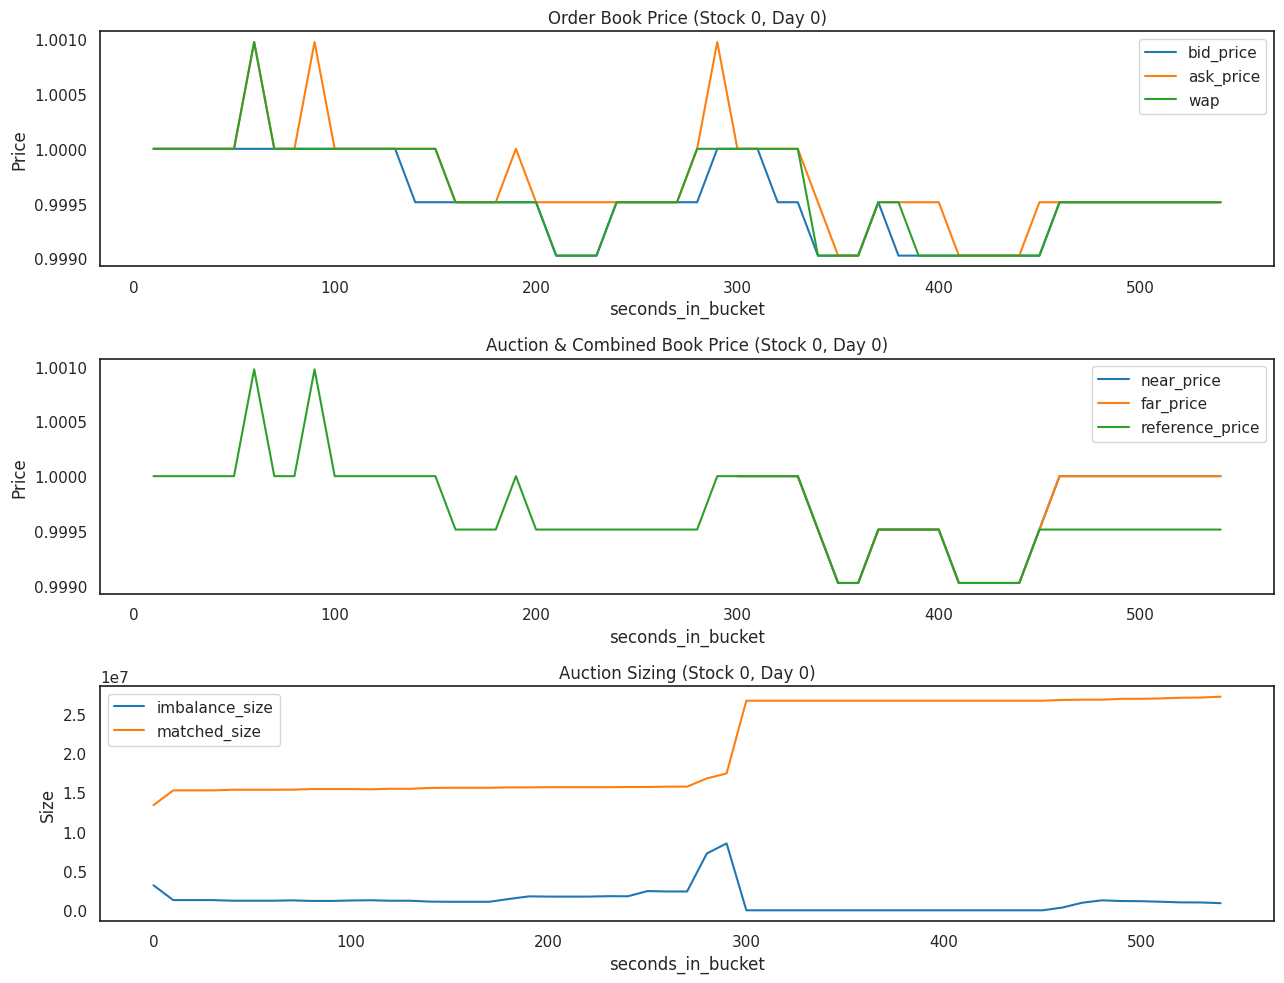

In [18]:
def plot_auction_examples(df):
    tmp = df.query('stock_id == 0 & date_id == 0')
    fig, axs = plt.subplots(3, 1, figsize=(13,10))
    color_list = ['#1f77b4', '#ff7f0e', '#2ca02c']

    tmp1 = tmp[['seconds_in_bucket', 'bid_price', 'ask_price', 'wap']].replace(0, np.nan).set_index('seconds_in_bucket')
    tmp1.plot(ax=axs[0], title='Order Book Price (Stock 0, Day 0)', color=color_list[:tmp1.shape[1]])
    axs[0].set_ylabel('Price')

    tmp2 = tmp[['seconds_in_bucket', 'near_price', 'far_price', 'reference_price']].replace(0, np.nan).set_index('seconds_in_bucket')
    tmp2.plot(ax=axs[1], title='Auction & Combined Book Price (Stock 0, Day 0)', color=color_list[:tmp2.shape[1]])
    axs[1].set_ylabel('Price')

    tmp3 = tmp[['seconds_in_bucket', 'imbalance_size', 'matched_size']].set_index('seconds_in_bucket')
    tmp3.plot(ax=axs[2], title='Auction Sizing (Stock 0, Day 0)', color=color_list[:tmp3.shape[1]])
    axs[2].set_ylabel('Size')

    plt.tight_layout()
    plt.show()

plot_auction_examples(train)

### **Visualization of Key Variable Distributions, Correlations, and Outliers**

In [19]:
num_cols = ['reference_price', 'far_price', 'near_price', 'ask_price', 'bid_price', 'wap', 'target']

**Distribution of main numerical features**

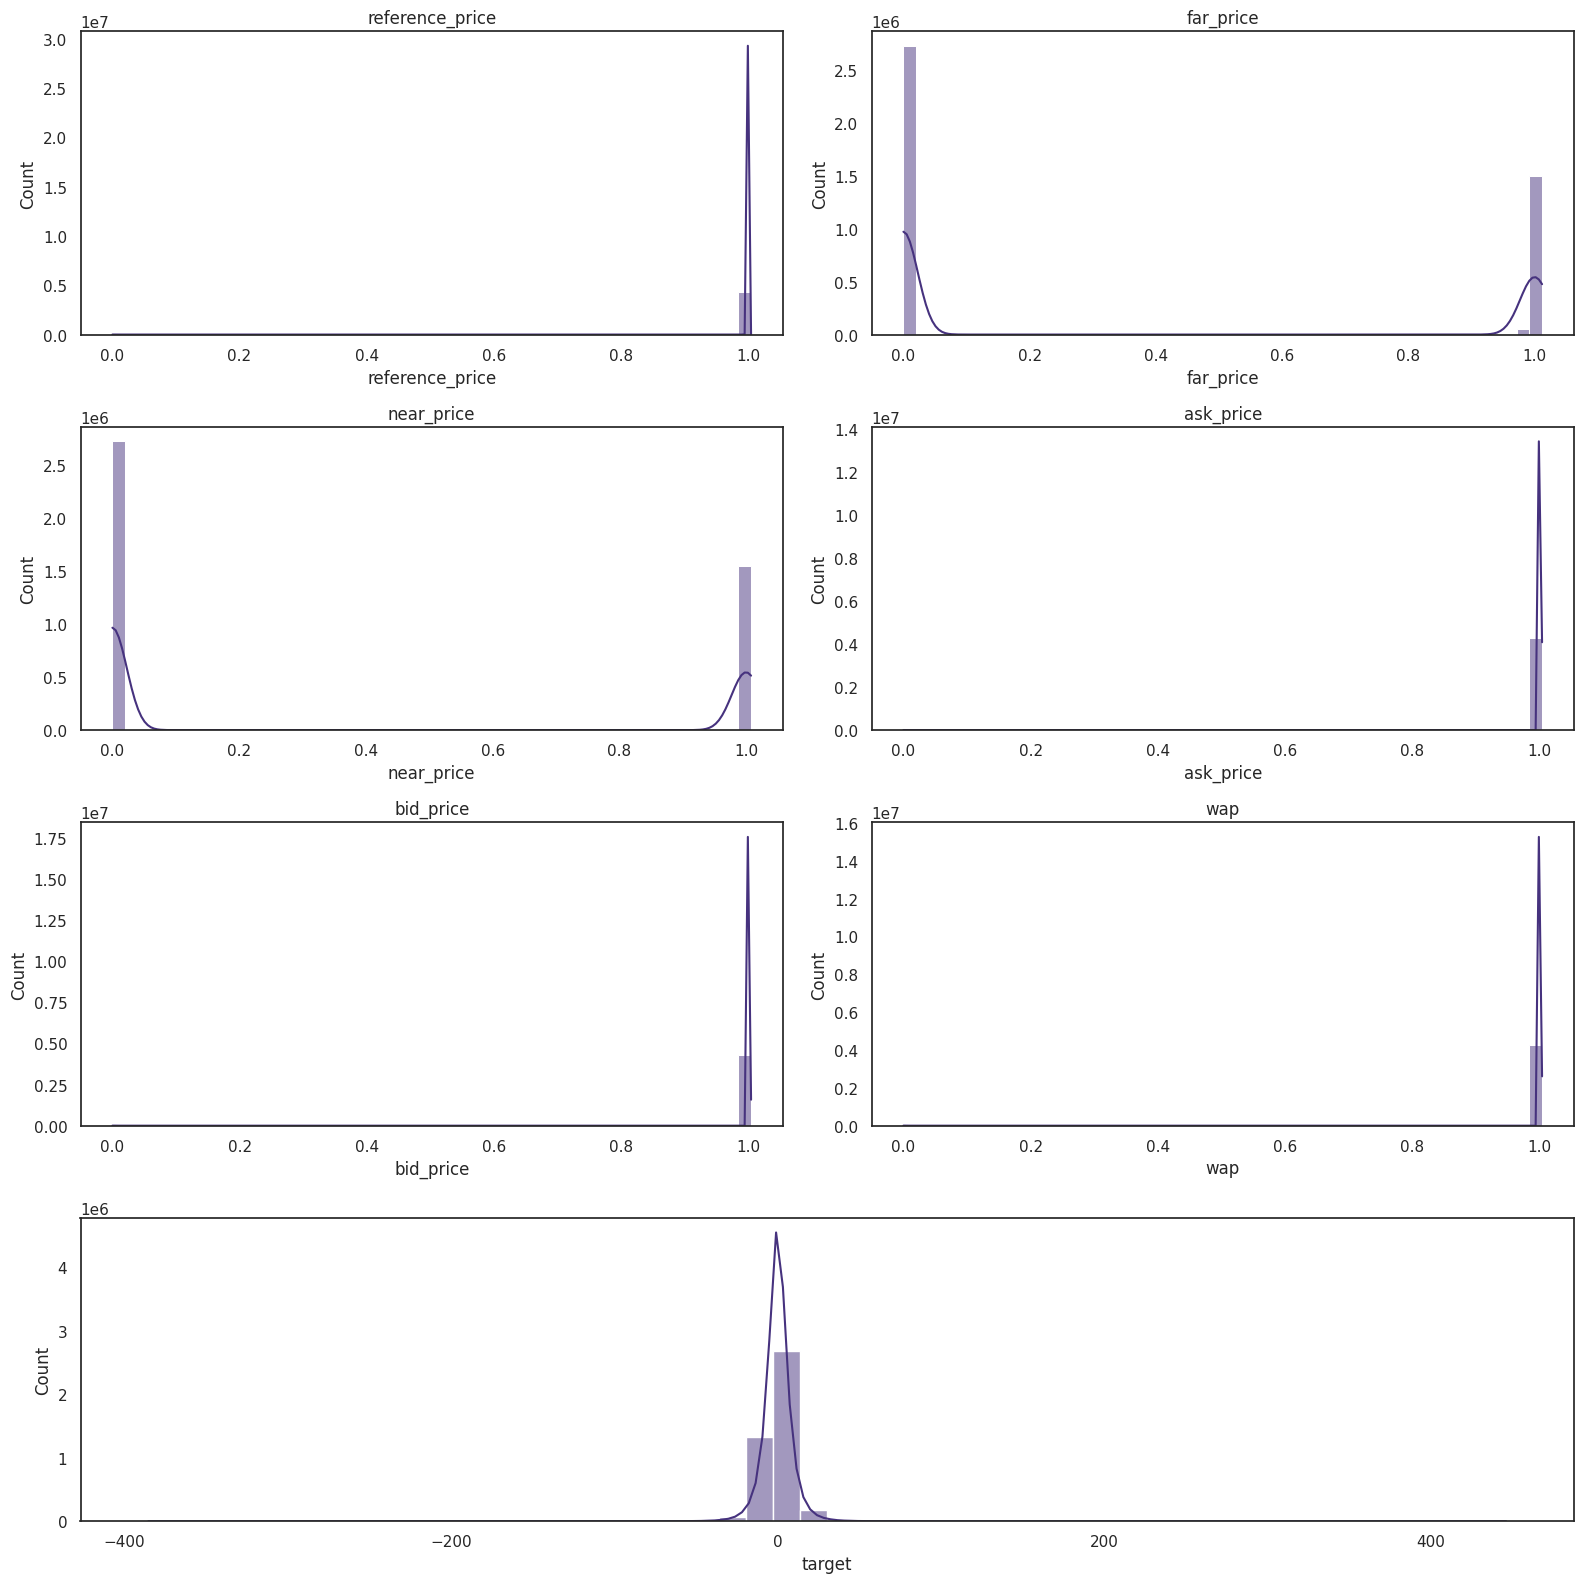

In [20]:
fig = plt.figure(figsize=(16,16))
gs = fig.add_gridspec(4,2)
for i, col in enumerate(num_cols[:-1]):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    sns.histplot(train[col], bins=50, kde=True, ax=ax)
    ax.set_title(col)
ax_target = fig.add_subplot(gs[3, :])
sns.histplot(train['target'], bins=50, kde=True, ax=ax_target)
plt.tight_layout()
plt.show()

**Correlation Heatmap (Numerical Features)**

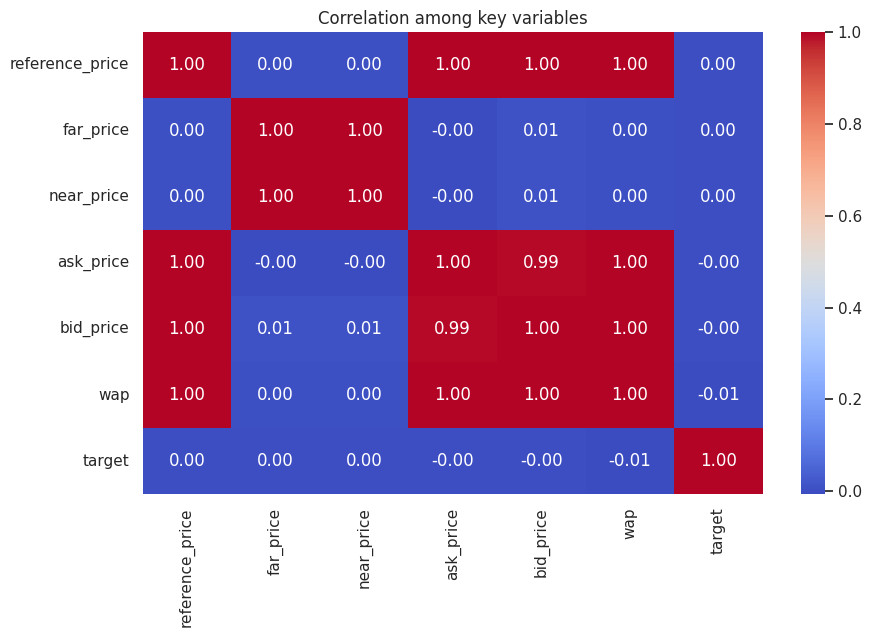

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(train[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation among key variables")
plt.show()

**Boxplot: Target by imbalance_buy_sell_flag**

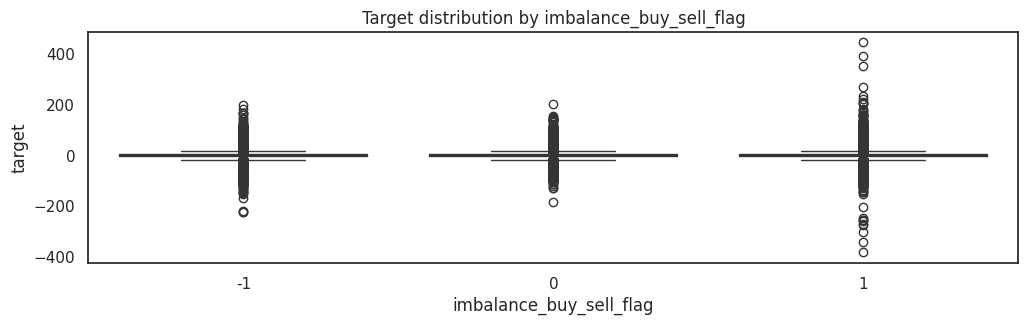

In [22]:
plt.figure(figsize=(12,3))
sns.boxplot(x='imbalance_buy_sell_flag', y='target', data=train)
plt.title('Target distribution by imbalance_buy_sell_flag')
plt.show()

**Average Target by Stock**

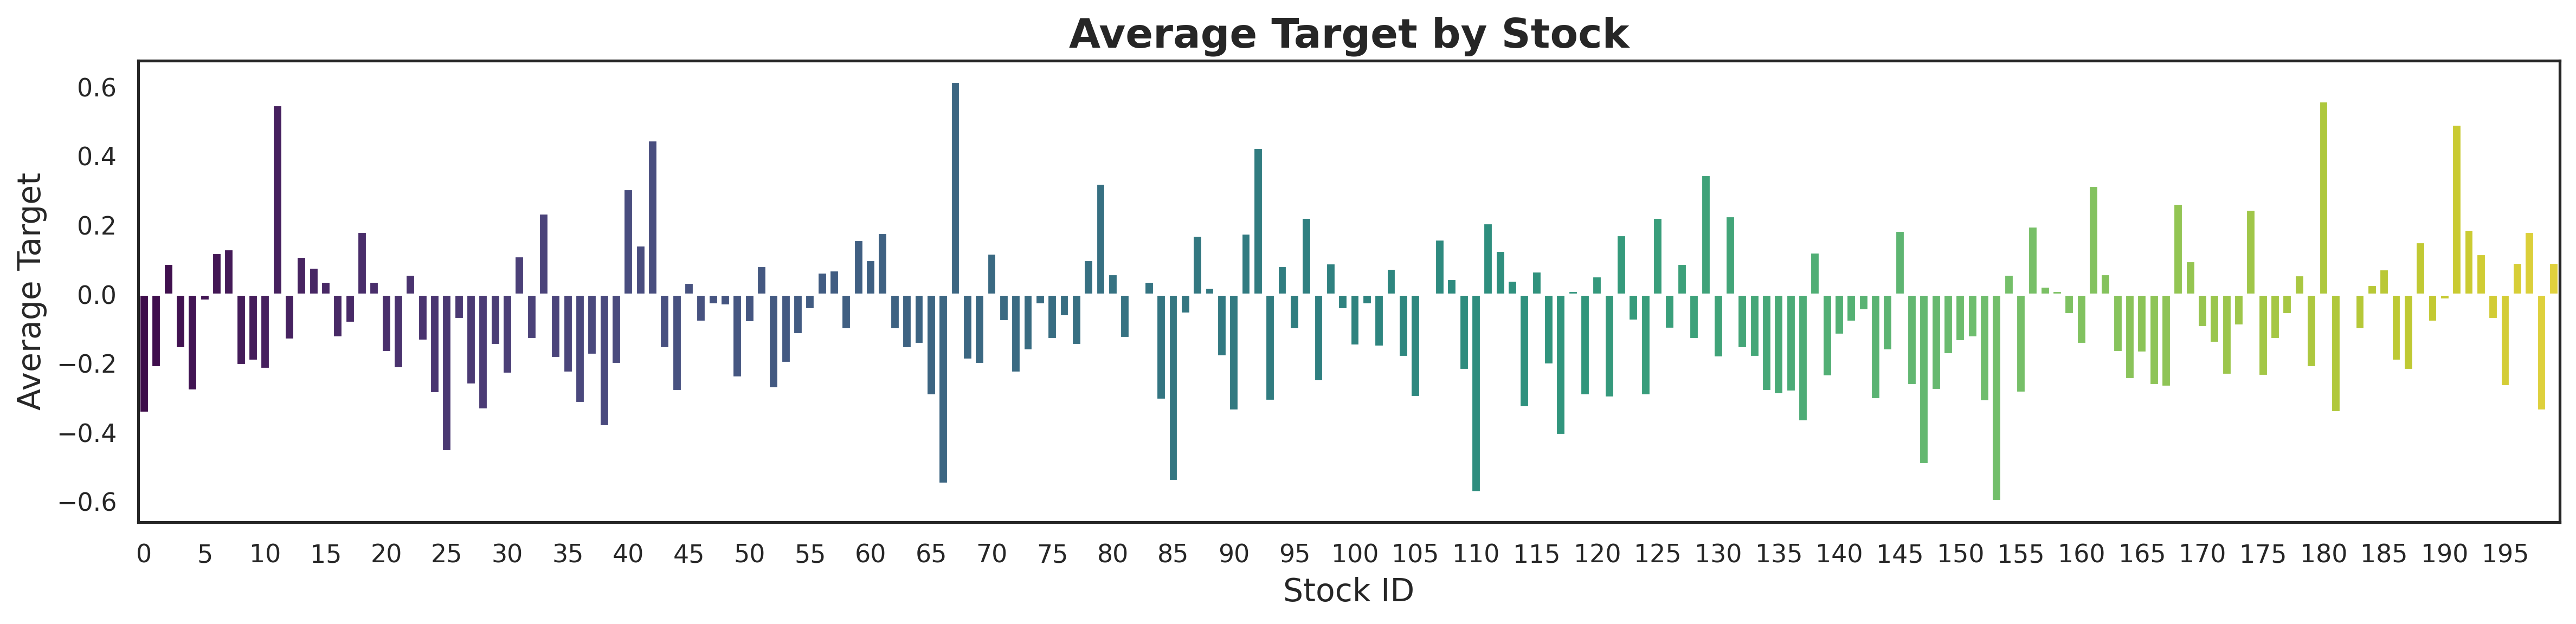

In [23]:
plt.figure(figsize=(16,4), dpi=300)
stock_avg = train.groupby('stock_id', as_index=False)['target'].mean()
sns.barplot(x='stock_id', y='target', data=stock_avg, palette='viridis')
plt.title('Average Target by Stock', fontsize=18, fontweight='bold')
plt.xlabel('Stock ID', fontsize=14)
plt.ylabel('Average Target', fontsize=14)
xticks = list(range(stock_avg['stock_id'].min(), stock_avg['stock_id'].max() + 1, 5))
plt.xticks(xticks)
plt.tight_layout()
plt.show()

**Average Target by Day**

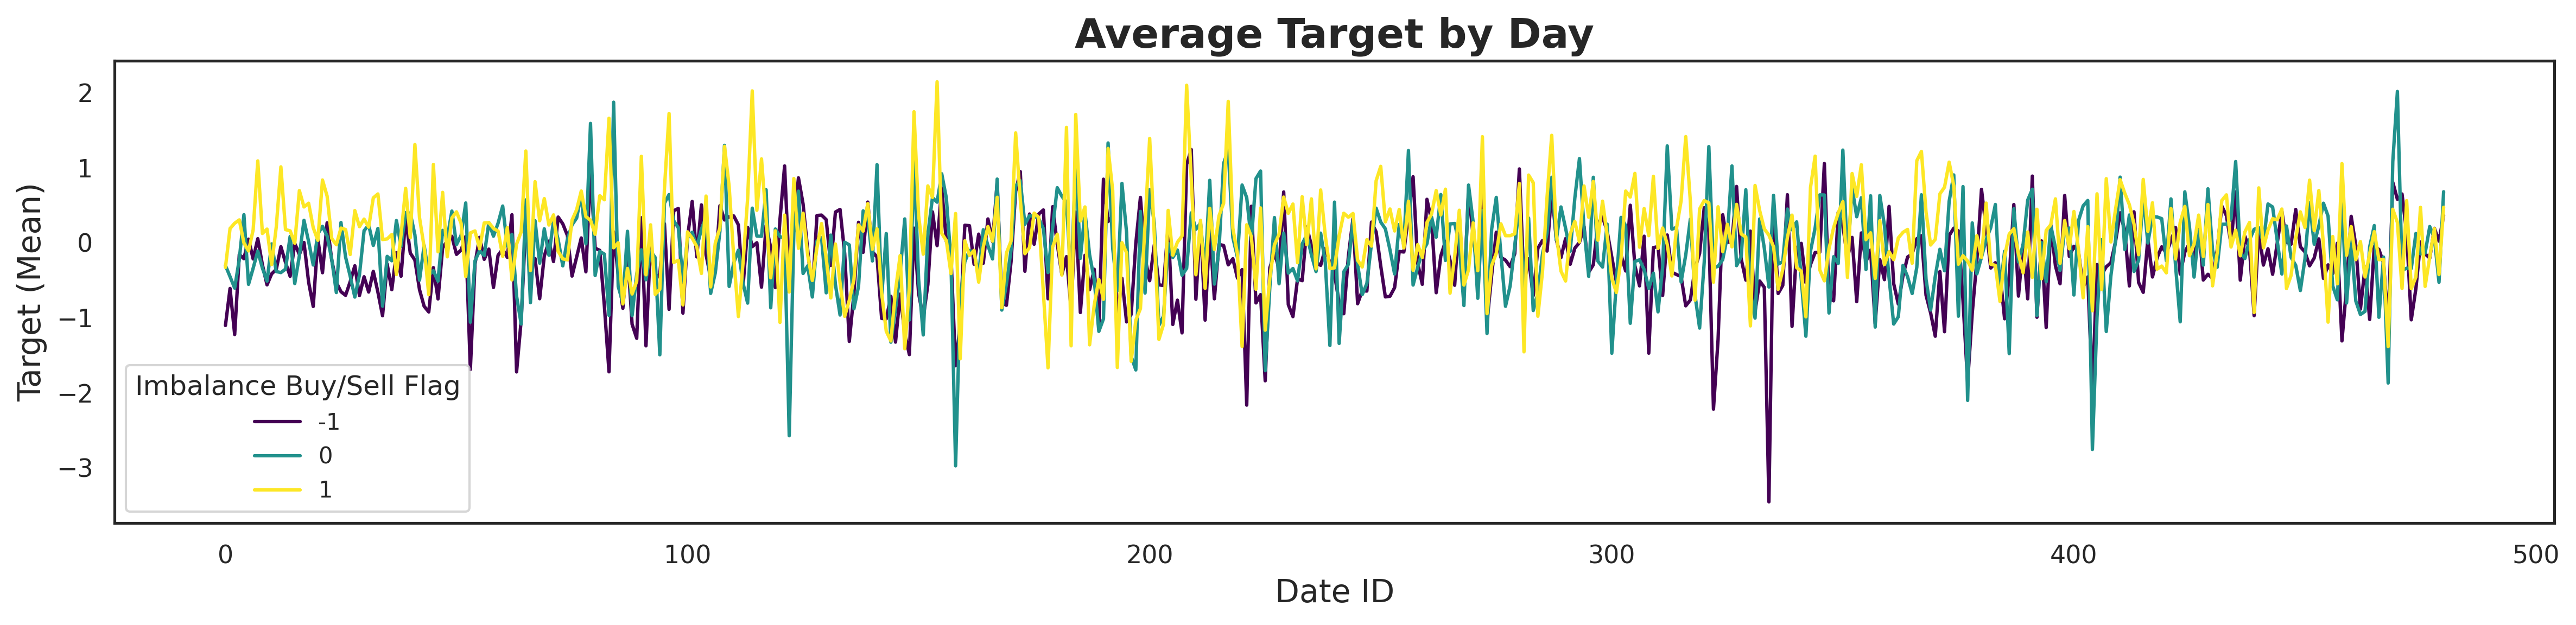

In [24]:
plt.figure(figsize=(16,4), dpi=300)
sns.lineplot(data=train, x='date_id', y='target', hue='imbalance_buy_sell_flag', errorbar=None, palette='viridis')
plt.title('Average Target by Day', fontsize=18, fontweight='bold')
plt.xlabel('Date ID', fontsize=14)
plt.ylabel('Target (Mean)', fontsize=14)
plt.legend(title='Imbalance Buy/Sell Flag', fontsize=10)
plt.tight_layout()
plt.show()

**Average Target Over Seconds in Bucket**

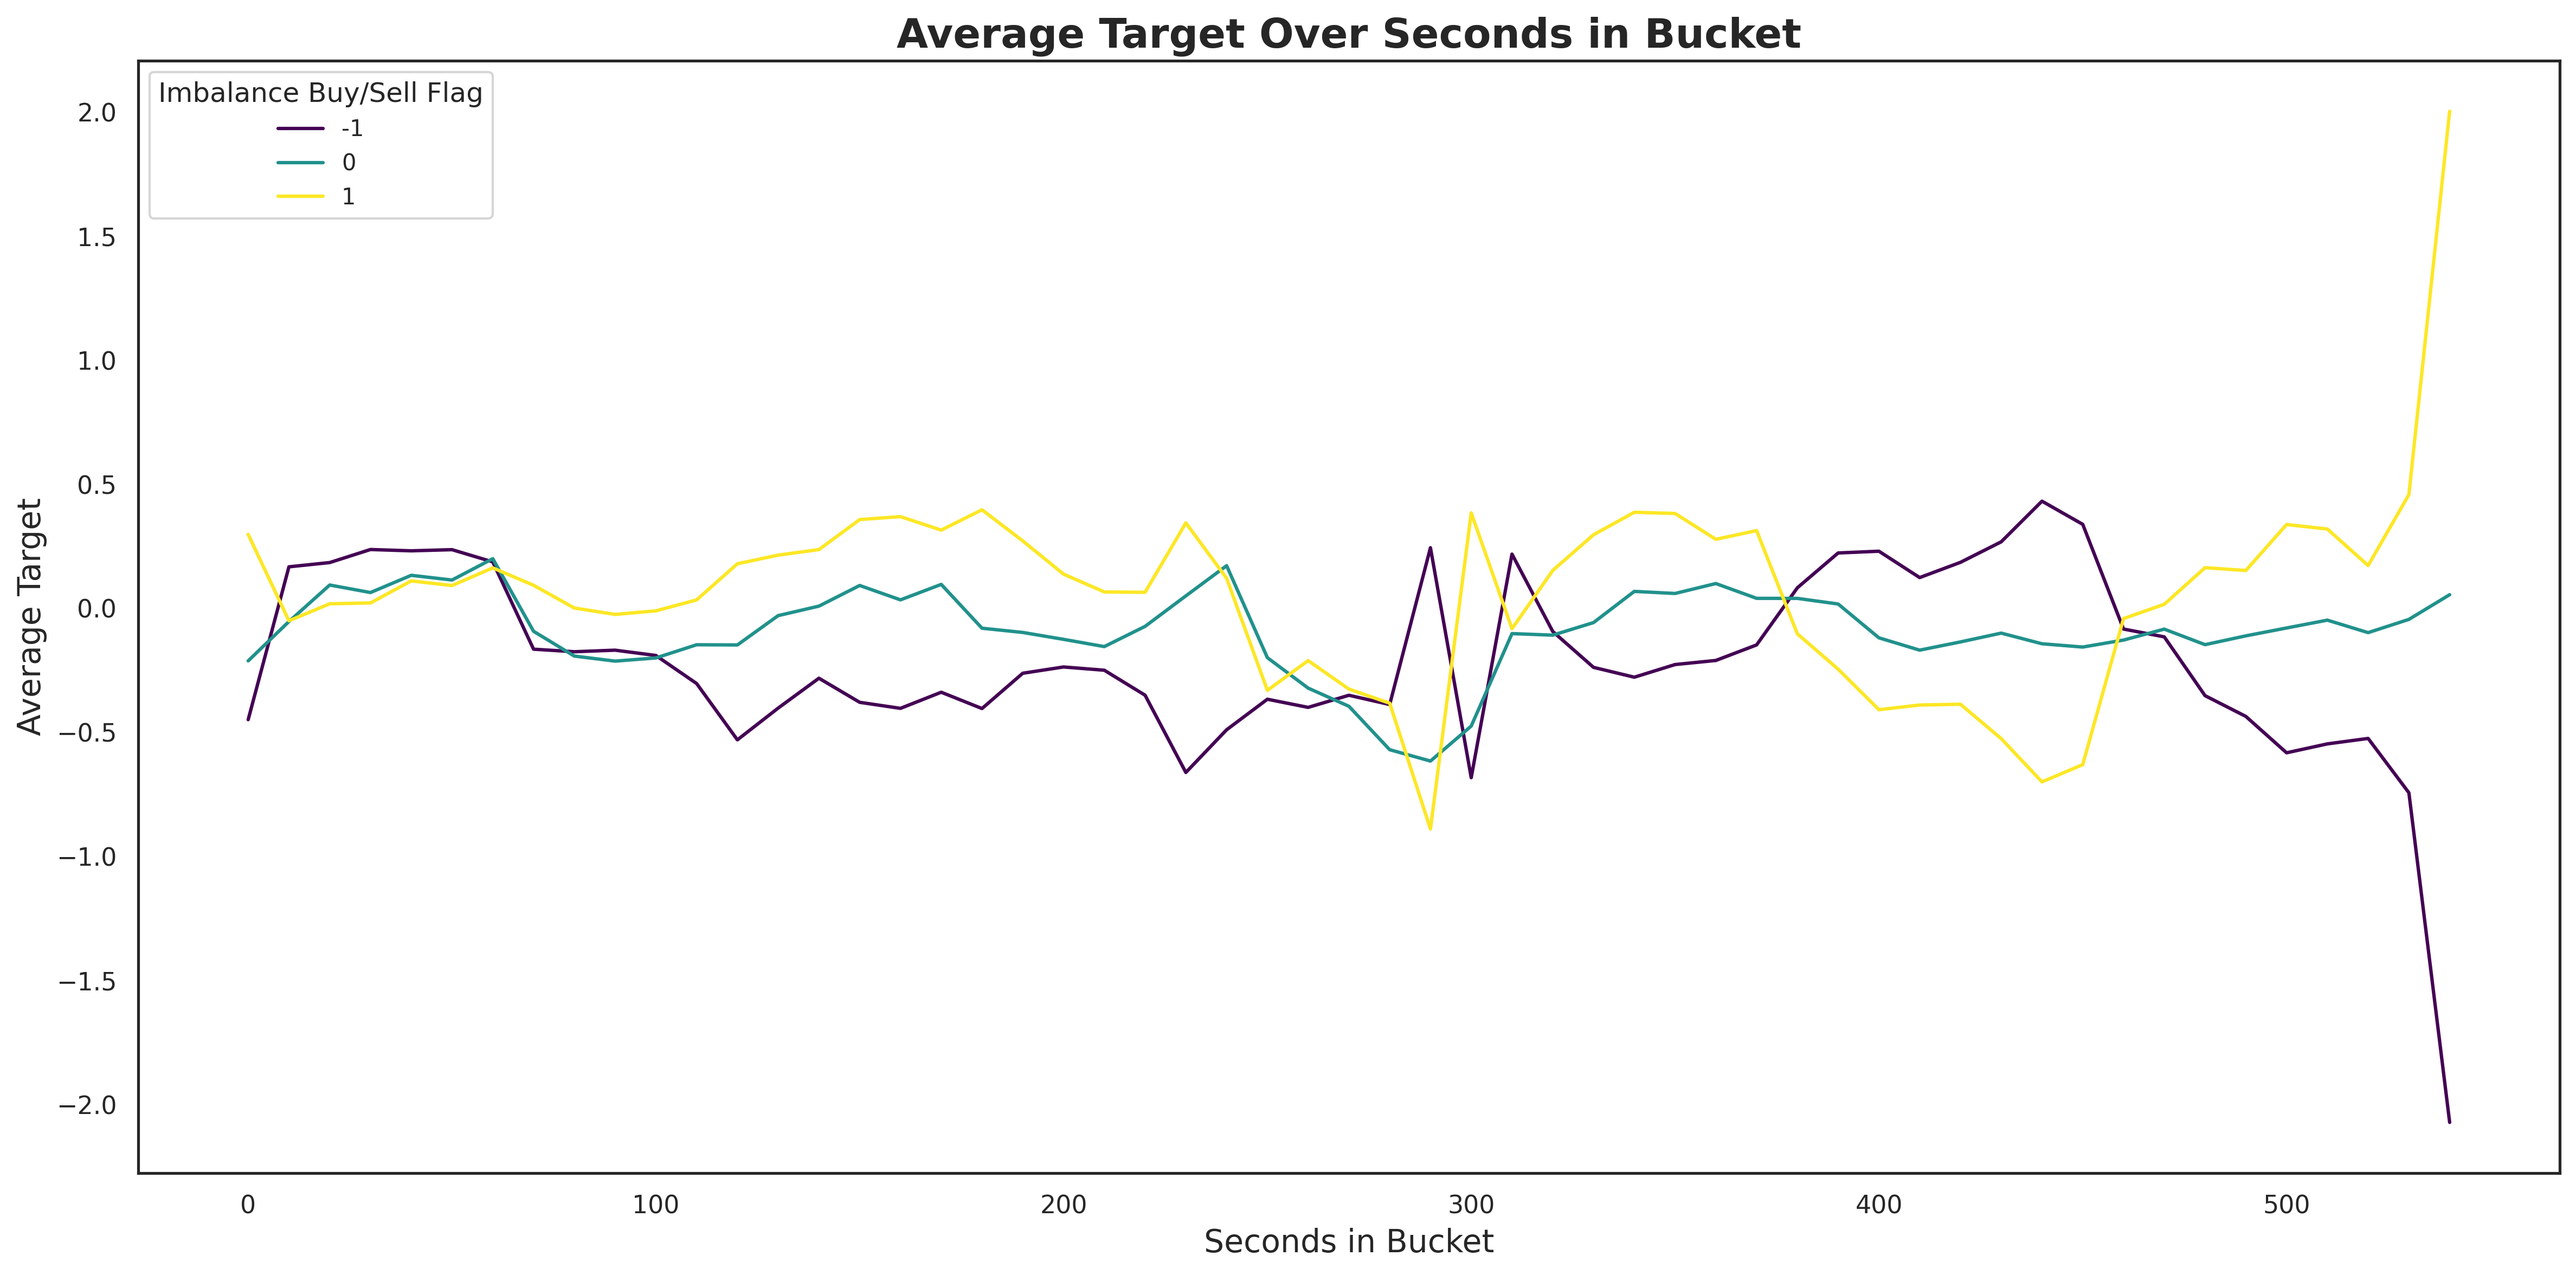

In [25]:
plt.figure(figsize=(16,8), dpi=300)
sns.lineplot(data=train, x='seconds_in_bucket', y='target', hue='imbalance_buy_sell_flag', errorbar=None, palette='viridis')
plt.title('Average Target Over Seconds in Bucket', fontsize=18, fontweight='bold')
plt.xlabel('Seconds in Bucket', fontsize=14)
plt.ylabel('Average Target', fontsize=14)
plt.legend(title='Imbalance Buy/Sell Flag', fontsize=10)
plt.tight_layout()
plt.show()

**Target time series for a random stock**

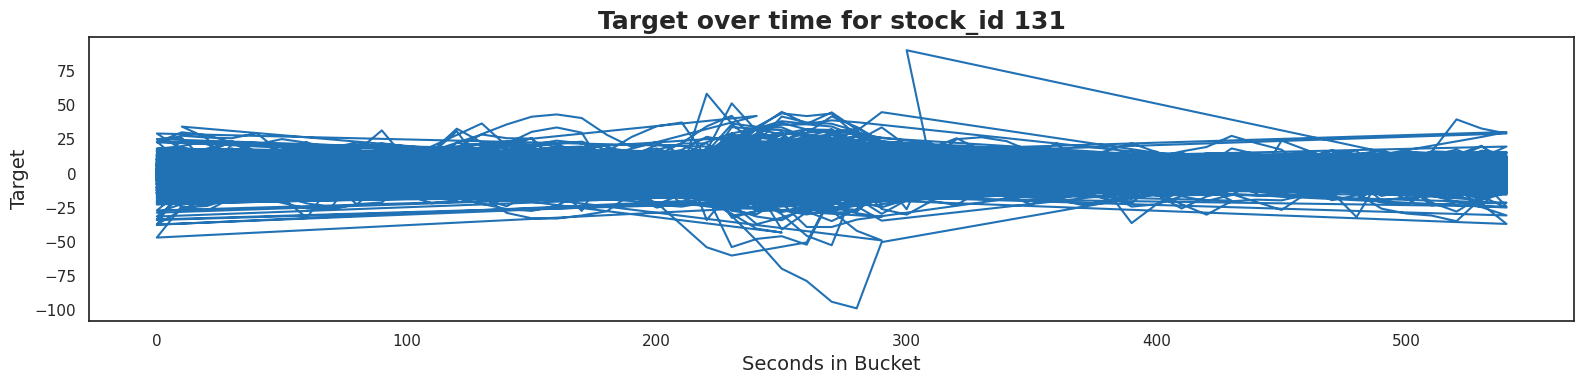

In [26]:
ex_stock = train['stock_id'].sample(1, random_state=42).values[0]
tmp = train[train['stock_id'] == ex_stock]
plt.figure(figsize=(16,4))
plt.plot(tmp['seconds_in_bucket'], tmp['target'], color='#2171b5')
plt.title(f'Target over time for stock_id {ex_stock}', fontsize=18, fontweight='bold')
plt.xlabel('Seconds in Bucket', fontsize=14)
plt.ylabel('Target', fontsize=14)
plt.tight_layout()
plt.show()

**Data Splitting**

In [27]:
SPLIT_DAY = 435
train_set = train[train['date_id'] <= SPLIT_DAY]
valid_set = train[train['date_id'] > SPLIT_DAY]
feature_cols = [c for c in train.columns if c not in ['row_id', 'time_id', 'date_id', 'target']]

print("Train set:", train_set.shape, "Valid set:", valid_set.shape)

Train set: (3875996, 26) Valid set: (403095, 26)


**Correlation heatmap**
**Group mean comparison by target variable**
**Time series check: Example of one day's trend for a specific stock**

## **V. Modeling**

#### **LGBM**

Features used: 22

===== Fold 1 Training =====
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 6.67894
[200]	valid_0's l1: 6.64616
[300]	valid_0's l1: 6.6303
[400]	valid_0's l1: 6.61934
[500]	valid_0's l1: 6.60985
[600]	valid_0's l1: 6.60174
[700]	valid_0's l1: 6.59479
[800]	valid_0's l1: 6.58899
[900]	valid_0's l1: 6.58232
[1000]	valid_0's l1: 6.57642
[1100]	valid_0's l1: 6.57085
[1200]	valid_0's l1: 6.56568
[1300]	valid_0's l1: 6.56055
[1400]	valid_0's l1: 6.55571
[1500]	valid_0's l1: 6.55124
[1600]	valid_0's l1: 6.54689
[1700]	valid_0's l1: 6.54273
[1800]	valid_0's l1: 6.53845
[1900]	valid_0's l1: 6.5344
[2000]	valid_0's l1: 6.53043
[2100]	valid_0's l1: 6.52629
[2200]	valid_0's l1: 6.5223
[2300]	valid_0's l1: 6.51848
[2400]	valid_0's l1: 6.51447
[2500]	valid_0's l1: 6.51042
[2600]	valid_0's l1: 6.50651
[2700]	valid_0's l1: 6.50318
[2800]	valid_0's l1: 6.49932
[2900]	valid_0's l1: 6.49585
[3000]	valid_0's l1: 6.49256
[3100]	valid_0's l1: 6.48901
[320

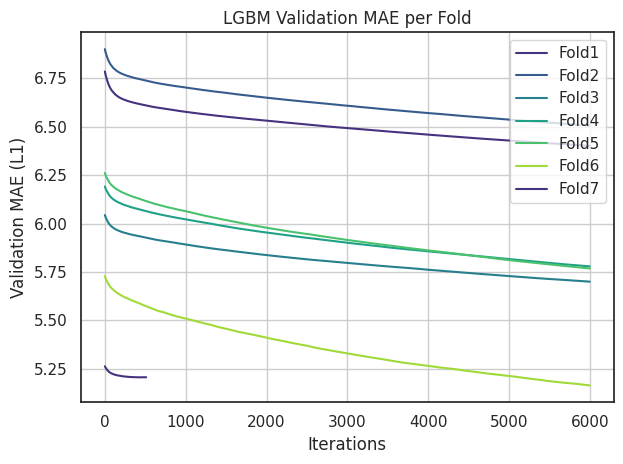

In [28]:
import lightgbm as lgb

lgbm_params = {
    "objective": "mae",
    "n_estimators": 6000,
    "num_leaves": 256,
    "subsample": 0.6,
    "colsample_bytree": 0.8,
    "learning_rate": 0.01,
    "max_depth": 11,
    "n_jobs": 4,
    "device": "gpu",
    "verbosity": -1,
    "importance_type": "gain",
    "reg_alpha": 0.2,
    "reg_lambda": 3.25
}

feature_cols = [c for c in train.columns if c not in ['row_id', 'time_id', 'date_id', 'target']]

n_folds = 7
fold_size = train['date_id'].nunique() // n_folds
gap = 5
models = []
val_mae_list = []

model_dir = 'lgbm_fold_models'
os.makedirs(model_dir, exist_ok=True)
date_ids = train['date_id'].values

print(f"Features used: {len(feature_cols)}")

for i in range(n_folds):
    start = i * fold_size
    end = start + fold_size
    if i < n_folds - 1:
        purged_start = end - 2
        purged_end = end + gap + 2
        train_idx = ((date_ids >= start) & (date_ids < purged_start)) | (date_ids > purged_end)
    else:
        train_idx = (date_ids >= start) & (date_ids < end)
    val_idx = (date_ids >= end) & (date_ids < end + fold_size)

    gc.collect()

    X_train = train.iloc[train_idx][feature_cols]
    y_train = train.iloc[train_idx]['target']
    X_valid = train.iloc[val_idx][feature_cols]
    y_valid = train.iloc[val_idx]['target']

    print(f"\n===== Fold {i+1} Training =====")
    lgbm = lgb.LGBMRegressor(**lgbm_params)
    evals_result = {}
    lgbm.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='mae',
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100),
            lgb.callback.record_evaluation(evals_result)
        ]
    )
    model_file = os.path.join(model_dir, f'lgbm_fold_{i+1}.txt')
    lgbm.booster_.save_model(model_file)
    print(f"[Fold {i+1}] Model saved: {model_file}")
    models.append(lgbm)

    # Validation MAE by fold
    val_pred = lgbm.predict(X_valid)
    fold_mae = mean_absolute_error(y_valid, val_pred)
    val_mae_list.append(fold_mae)
    print(f"[Fold {i+1}] Validation MAE: {fold_mae:.5f}")
    plt.plot(evals_result['valid_0']['l1'], label=f'Fold{i+1}')
    del X_train, y_train, X_valid, y_valid
    gc.collect()

plt.xlabel('Iterations')
plt.ylabel('Validation MAE (L1)')
plt.title('LGBM Validation MAE per Fold')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### **Test Prediction and Results**

In [30]:
test_pred = np.zeros(len(test))
for model in models:
    test_pred += model.predict(test[feature_cols])
test_pred /= len(models)
test_pred = np.clip(test_pred, -64, 64)

submission['target'] = test_pred
submission.to_csv('/content/drive/MyDrive/DataAnalytics/submission.csv', index=False)
results = pd.read_csv('/content/drive/MyDrive/DataAnalytics/submission.csv')
results

,time_id,row_id,target
0,26290,478_0_0,-1.675288
1,26290,478_0_1,1.442121
2,26290,478_0_2,4.203721
3,26290,478_0_3,-0.339844
4,26290,478_0_4,-1.461759
...,...,...,...
32995,26454,480_540_195,-1.602034
32996,26454,480_540_196,-2.175987
32997,26454,480_540_197,0.074780
32998,26454,480_540_198,1.327101


## **VI. Conclusion and Insights**

The primary objective of this project was to forecast the volume-weighted average price (WAP, target) 60 seconds ahead using real-world financial market data. The dataset contains a significant number of missing values and outliers, closely reflecting real-world trading conditions.

**1. Handling Missing Values**

  Columns such as far_price (55% missing) and near_price (54% missing) exhibited high rates of missingness.

  To minimize information loss, we converted these columns to float and left missing values as-is, without further imputation or interpolation. This approach allowed the model to directly learn from the raw data distribution.

**2. Outlier Removal**

  Outliers were filtered using the Interquartile Range (IQR) method for each price-related variable. For instance, over 320,000 rows were removed from reference_price and over 650,000 from far_price. Overall, 5-12% of rows per variable were identified and removed as outliers.

**3. EDA Findings**

  All main price columns had means close to 1.0 and very narrow standard deviations (typically 0.002-0.007). The target variable was nearly centered at zero (mean ≈ 0.03, std ≈ 5.6), showing stable distribution even after outlier removal. Correlation analysis confirmed strong inter-correlation among price features (0.94-0.97), but almost no linear correlation between any feature and the target (max correlation ~0.01).

**4. Feature Engineering and Importance**

  Derived features included liquidity/volume metrics (bid_size, ask_size, volume), spreads, and volatility. Feature importance analysis consistently ranked liquidity and volume-related features highest, reflecting their relevance in high-frequency trading.

**5. Model Performance**

  The 7-fold LightGBM regression model produced validation MAEs of [6.40, 6.51, 5.70, 5.78, 5.77, 5.16, 5.21], with the final fold MAE being 5.21.
  
  This result demonstrates that, for a single regression model, the achieved performance is quite strong given the data and environment.
  Additionally, the distribution of predicted values closely matched that of the actual target, confirming that the model was well-calibrated.

**6. Practical Insights**

  Through this project, I gained practical experience with the entire data science workflow—including data preprocessing, feature engineering, modeling, and interpretation—using real, noisy financial data.

  Ultimately, the results reaffirmed the inherent challenges of short-term price forecasting in high-frequency financial markets with tabular machine learning, and highlighted the importance of rigorous data processing and conservative modeling.
  Future improvements are likely to require advanced time-series models, ensembling, or domain-specific feature engineering.